In [ ]:
import pandas as pd
import numpy as np
import torch
df = pd.read_csv(r'/content/Metabolic Syndrome.csv')



In [ ]:
print(len(df))
df = df.dropna()
print(len(df))
df.head()
df.reset_index()

2401
2009


,index,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,5,62178,80,Male,Widowed,300.0,White,112.5,28.5,0,9.79,4.8,105,47,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,2394,71895,31,Male,Married,2500.0,Asian,74.0,20.6,0,2.00,6.7,95,64,81,0
2005,2395,71898,65,Female,Married,5400.0,MexAmerican,98.5,29.4,0,5.51,6.7,114,49,165,1
2006,2398,71909,28,Male,Single,800.0,MexAmerican,100.8,29.4,0,2.78,6.2,99,47,84,0
2007,2399,71911,27,Male,Married,8200.0,MexAmerican,106.6,31.3,0,4.15,6.2,100,41,124,1


normalizing numeric columns

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Age', 'Income', 'WaistCirc','BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL' , 'Triglycerides']

subset_to_normalize = df[columns_to_normalize]

scaler = StandardScaler()

normalized_values = scaler.fit_transform(subset_to_normalize)

df[columns_to_normalize] = normalized_values


one hot encoding catageorical variables

In [ ]:
columns_to_encode = ['Sex', 'Marital', 'Race']

df_encoded = pd.get_dummies(df, columns=columns_to_encode)



In [ ]:

print(len(df_encoded.columns))
print(df.columns)

df_encoded = df_encoded.drop(['seqn'], axis = 1)
df_encoded = df_encoded.reset_index(drop=True)

df_encoded.head()


25
Index(['seqn', 'Age', 'Sex', 'Marital', 'Income', 'Race', 'WaistCirc', 'BMI',
       'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL',
       'Triglycerides', 'MetabolicSyndrome'],
      dtype='object')


,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,...,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
0,-1.565320,1.358247,-1.074950,-0.825925,-0.35381,-0.158988,-0.414060,-0.476040,-0.836256,-0.477671,...,0,0,1,0,0,0,0,0,0,1
1,-0.302216,0.118240,-1.130157,-0.841126,-0.35381,-0.139640,-0.694072,-0.773408,-1.702426,-0.789488,...,1,0,0,0,0,0,0,0,0,1
2,-1.622734,-1.121766,-1.774238,-1.312344,-0.35381,-0.154058,-0.064045,-0.029988,-0.702999,-0.544489,...,0,0,1,0,1,0,0,0,0,0
3,-0.359630,-0.719602,1.341889,0.694136,-0.35381,-0.153436,-0.344057,-0.119199,1.295856,0.157101,...,0,0,1,0,0,1,0,0,0,0
4,1.764683,-1.289335,0.857294,-0.035493,-0.35381,-0.134502,-0.484063,-0.089462,-0.436485,-0.299489,...,0,0,0,1,0,0,0,0,0,1


pytorch dataset defintion

In [ ]:
from torch.utils.data import Dataset

class MetabolicSyndromeData(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.targets = self.dataframe['MetabolicSyndrome']
        self.features = self.dataframe.drop(columns=['MetabolicSyndrome','index']).values
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)

        if self.transform:
            features = self.transform(features)

        return features, target


Load data into dataloader

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

train_df = train_df.reset_index()
test_df = test_df.reset_index()

train_dataset = MetabolicSyndromeData(dataframe=train_df)
test_dataset = MetabolicSyndromeData(dataframe=test_df)



batch_size = 1
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


MLP Network definitions

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, Hidden_size_one, Hidden_size_two):
        super().__init__()
        # Define your layers here!!
        # YOUR CODE HERE
        self.fc = nn.Linear(in_features = 23,out_features= Hidden_size_one, bias = True)
        self.fc1 = nn.Linear(in_features= Hidden_size_one ,out_features= Hidden_size_two, bias = True)
        self.fc2 = nn.Linear(in_features= Hidden_size_two, out_features= 1, bias = True)
        self.selu = nn.SELU(inplace=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.fc(x)
        x = self.selu(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [ ]:
class ShallowMLP(nn.Module):
    def __init__(self, Hidden_size):
        super().__init__()
        # Define your layers here!!
        # YOUR CODE HERE
        self.fc = nn.Linear(in_features = 23,out_features= Hidden_size, bias = True)
        self.fc2 = nn.Linear( in_features = Hidden_size, out_features= 1, bias = True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.fc(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

Training Logic

In [ ]:
learning_rate = 1e-4
n_epochs = 50

# Use BCEWithLogitsLoss for binary classification
mlp = ShallowMLP(75)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assuming ShallowMLP is a binary classification model

def train(model, optimizer, criterion ,learning_rate, n_epochs, trainloader, device, printbool):
  for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

  criterion.to(device)
  model.to(device)
  for epoch in range(n_epochs):
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data

          # Assuming labels are in the range [0, 1], if not, preprocess accordingly
          labels = labels.float().to(device)

          output = model(inputs.to(device))

          loss = criterion(output, labels.view(-1, 1))  # Ensure labels have shape (batch_size, 1)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if i % 10 == 9 and printbool:
            print('[Epoch %d, Step %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
  print('Finished Training')

train(model = mlp, optimizer= optimizer, criterion= criterion, learning_rate = learning_rate, n_epochs = n_epochs, trainloader = trainloader, device = device, printbool = True )


[Epoch 1, Step    10] loss: 0.758
[Epoch 1, Step    20] loss: 0.696
[Epoch 1, Step    30] loss: 0.729
[Epoch 1, Step    40] loss: 0.737
[Epoch 1, Step    50] loss: 0.698
[Epoch 1, Step    60] loss: 0.730
[Epoch 1, Step    70] loss: 0.714
[Epoch 1, Step    80] loss: 0.744
[Epoch 1, Step    90] loss: 0.726
[Epoch 1, Step   100] loss: 0.729
[Epoch 1, Step   110] loss: 0.665
[Epoch 1, Step   120] loss: 0.715
[Epoch 1, Step   130] loss: 0.700
[Epoch 1, Step   140] loss: 0.685
[Epoch 1, Step   150] loss: 0.689
[Epoch 1, Step   160] loss: 0.693
[Epoch 1, Step   170] loss: 0.687
[Epoch 1, Step   180] loss: 0.676
[Epoch 1, Step   190] loss: 0.673
[Epoch 1, Step   200] loss: 0.679
[Epoch 1, Step   210] loss: 0.699
[Epoch 1, Step   220] loss: 0.680
[Epoch 1, Step   230] loss: 0.648
[Epoch 1, Step   240] loss: 0.668
[Epoch 1, Step   250] loss: 0.656
[Epoch 1, Step   260] loss: 0.659
[Epoch 1, Step   270] loss: 0.679
[Epoch 1, Step   280] loss: 0.637
[Epoch 1, Step   290] loss: 0.691
[Epoch 1, Step

KeyboardInterrupt: ignored

Eval logic

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

def eval(model,testloader,device):
    # Move the model to CPU
    model.cpu()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            # Move data to CPU
            inputs = inputs.cpu()
            labels = labels.cpu()

            outputs = model(inputs)

            outputs = torch.round(outputs)

            # Append NumPy arrays instead of tensors
            all_labels.extend(labels.numpy())
            all_predicted.extend(outputs.numpy())

    # Calculate F1 score
    f1 = f1_score(all_labels, all_predicted, average='weighted')
    print('F1 Score: %.2f' % f1)

    # Convert to NumPy arrays before using classification_report
    all_labels = np.array(all_labels)
    all_predicted = np.array(all_predicted)

    class_report = classification_report(all_labels, all_predicted)
    accuracy = accuracy_score(all_labels, all_predicted)
    confusion_Mat = confusion_matrix(all_labels, all_predicted)
    print('Classification Report:\n', class_report)
    model.to(device)
    return f1, accuracy, confusion_Mat
eval(model = mlp, testloader = testloader,device = device)


F1 Score: 0.63
Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.73      0.72       255
         1.0       0.50      0.46      0.48       147

    accuracy                           0.63       402
   macro avg       0.60      0.60      0.60       402
weighted avg       0.63      0.63      0.63       402



(0.6288991122394527,
 0.6318407960199005,
 array([[186,  69],
        [ 79,  68]]))

Grid Search

In [ ]:
from itertools import product

grid = {'Hidden_size':[10,50,75,100],
        'Learning Rate': [0.001,0.01,0.1,1],
        'Epochs': [10,20,50,100],
        }


all_param_combinations = list(product(*grid.values()))
f1s = []
maxf1 = 0
maxf1index = 0
for params in all_param_combinations:
    gmlp = ShallowMLP(params[0])
    optimizer = torch.optim.Adam(gmlp.parameters(), lr=(params[1]))
    train(model = gmlp, optimizer =  optimizer, criterion = criterion ,learning_rate = (params[1]) , n_epochs = (params[2]), trainloader = trainloader, device = device, printbool = False)
    f1, _, _ = eval(model = gmlp, testloader = testloader , device = device)
    f1s.append(f1)

for index, score in f1s:
  if score > maxf1:
    maxf1 = score
    maxf1index = index

best_params = all_param_combinations[maxf1index]




Finished Training
F1 Score: 0.80
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       255
         1.0       0.71      0.78      0.74       147

    accuracy                           0.80       402
   macro avg       0.79      0.80      0.79       402
weighted avg       0.81      0.80      0.80       402



KeyboardInterrupt: ignored

In [ ]:
best_params = all_param_combinations[50]

print(best_params)

best_params = all_param_combinations[3]

print(best_params)


(100, 0.001, 50)
(10, 0.001, 100)


Cross validation

In [ ]:
# cross VAL for best grid search model
k = 5
fold_size = len(df_encoded) // k

hidden_size = 10
lr = 0.001
epochs = 500
criterion = nn.BCELoss()
mean_accuracy = 0
mean_f1 = 0

for fold in range(k):
    # Define train and validation indices for this fold
    bestMLP = ShallowMLP(hidden_size)
    optimizer = torch.optim.Adam(bestMLP.parameters(), lr=lr)

    val_start = fold * fold_size
    val_end = (fold + 1) * fold_size
    kval_data = df_encoded.iloc[val_start:val_end]

    ktrain_data = pd.concat([df_encoded.iloc[:val_start], df_encoded.iloc[val_end:]])
    kval_data = kval_data.reset_index()
    ktrain_data = ktrain_data.reset_index()
    ktrain_dataset = MetabolicSyndromeData(dataframe = ktrain_data)
    ktest_dataset = MetabolicSyndromeData(dataframe = kval_data)

    kbatch_size = 10
    ktrain_loader = DataLoader(ktrain_dataset, batch_size=batch_size, shuffle=True)
    ktest_loader = DataLoader(ktest_dataset, batch_size=batch_size, shuffle=True)

    train(model = bestMLP, optimizer = optimizer, criterion = criterion ,learning_rate = lr, n_epochs = epochs, trainloader = ktrain_loader, device = device, printbool = True)
    f1, accuracy, _ = eval(bestMLP, ktest_loader,device)
    mean_accuracy += accuracy
    mean_f1 += f1

mean_f1 =  mean_f1 / 5.0
mean_accuracy = mean_accuracy / 5.0
print('Cross Val f1')
print(mean_f1)
print('Cross Val Accuracy')
print(mean_accuracy)


Streaming output truncated to the last 5000 lines.
[Epoch 19, Step  1370] loss: 0.070
[Epoch 19, Step  1380] loss: 0.199
[Epoch 19, Step  1390] loss: 0.438
[Epoch 19, Step  1400] loss: 0.099
[Epoch 19, Step  1410] loss: 0.286
[Epoch 19, Step  1420] loss: 0.320
[Epoch 19, Step  1430] loss: 0.405
[Epoch 19, Step  1440] loss: 0.063
[Epoch 19, Step  1450] loss: 0.099
[Epoch 19, Step  1460] loss: 0.197
[Epoch 19, Step  1470] loss: 0.152
[Epoch 19, Step  1480] loss: 0.041
[Epoch 19, Step  1490] loss: 0.205
[Epoch 19, Step  1500] loss: 0.232
[Epoch 19, Step  1510] loss: 0.331
[Epoch 19, Step  1520] loss: 0.419
[Epoch 19, Step  1530] loss: 0.334
[Epoch 19, Step  1540] loss: 0.448
[Epoch 19, Step  1550] loss: 0.120
[Epoch 19, Step  1560] loss: 0.381
[Epoch 19, Step  1570] loss: 0.152
[Epoch 19, Step  1580] loss: 0.688
[Epoch 19, Step  1590] loss: 0.347
[Epoch 19, Step  1600] loss: 0.501
[Epoch 20, Step    10] loss: 0.246
[Epoch 20, Step    20] loss: 0.463
[Epoch 20, Step    30] loss: 0.219
[Epo

Confusion matrix

Streaming output truncated to the last 5000 lines.
[Epoch 69, Step  1330] loss: 0.349
[Epoch 69, Step  1340] loss: 0.238
[Epoch 69, Step  1350] loss: 0.214
[Epoch 69, Step  1360] loss: 0.094
[Epoch 69, Step  1370] loss: 0.098
[Epoch 69, Step  1380] loss: 0.249
[Epoch 69, Step  1390] loss: 0.247
[Epoch 69, Step  1400] loss: 0.118
[Epoch 69, Step  1410] loss: 0.271
[Epoch 69, Step  1420] loss: 0.111
[Epoch 69, Step  1430] loss: 0.411
[Epoch 69, Step  1440] loss: 0.421
[Epoch 69, Step  1450] loss: 0.081
[Epoch 69, Step  1460] loss: 0.132
[Epoch 69, Step  1470] loss: 0.370
[Epoch 69, Step  1480] loss: 0.226
[Epoch 69, Step  1490] loss: 0.233
[Epoch 69, Step  1500] loss: 0.428
[Epoch 69, Step  1510] loss: 0.494
[Epoch 69, Step  1520] loss: 0.122
[Epoch 69, Step  1530] loss: 0.019
[Epoch 69, Step  1540] loss: 0.132
[Epoch 69, Step  1550] loss: 0.237
[Epoch 69, Step  1560] loss: 0.126
[Epoch 69, Step  1570] loss: 0.209
[Epoch 69, Step  1580] loss: 0.204
[Epoch 69, Step  1590] loss: 0.209
[Epo

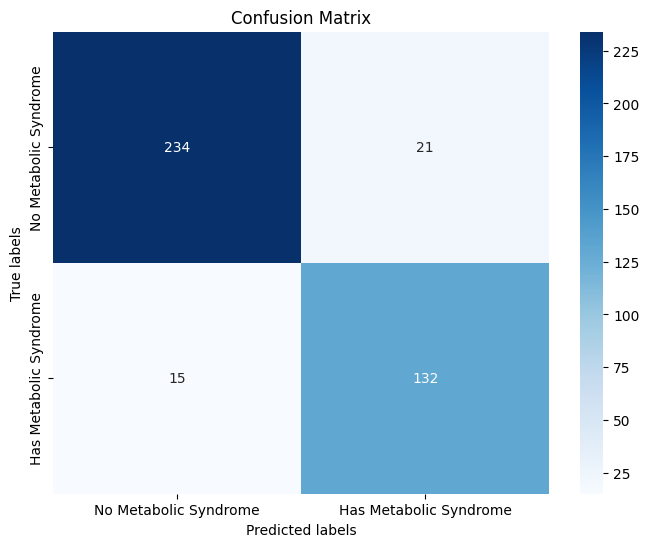

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

hidden_size = 10
lr = 0.001
epochs = 100
criterion = nn.BCELoss()


bestMLP = ShallowMLP(hidden_size)
optimizer = torch.optim.Adam(bestMLP.parameters(), lr=lr)
train(model = bestMLP, optimizer = optimizer, criterion = criterion ,learning_rate = lr, n_epochs = epochs, trainloader = ktrain_loader, device = device, printbool = True)

_, _, conf_matrix_mlp = eval(model = bestMLP,testloader = testloader, device = device)

#plot confusion
labels = ['No Metabolic Syndrome', 'Has Metabolic Syndrome']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
